# Genshin Impact Lore Hybrid QA System with Knowledge Graph + RAG + BM25

This notebook demonstrates a hybrid QA (Question Answering) system that combines:
- Neo4j knowledge graph (structured relationships)
- RAG (Retrieval-Augmented Generation) using Gemini Embeddings + Chroma
- BM25 sparse retrieval using keyword matching

All data is extracted from the **[Genshin Impact Archon Quest Wiki](https://genshin-impact.fandom.com/wiki/Archon_Quest)


---

### Technologies Used

- **Gemini 1.5 Pro** – for rewriting, decomposing, expanding, summarizing
- **LangChain** – for prompt templates, document handling, retrievers
- **Neo4j** – stores the structured knowledge graph
- **Chroma** – stores vector embeddings for narrative-based RAG
- **BM25Retriever** – indexes full-text wiki content for keyword-based fallback search

---

### Example Use Case

**Query**: `"what's paimon's deal with zhongli?"`

**System Actions**:
1. Rewrites the query for clarity
2. Decomposes it into simpler sub-questions
3. Expands those queries into 15–20 variations
4. Retrieves relevant information from:
   - KG (via Cypher query in Neo4j)
   - RAG (semantic search over chunked narrative)
   - BM25 (keyword-based match from raw text)
5. Synthesizes the final story using Gemini in formal narrative style

**Output**: A complete, grounded lore summary using only retrieved facts

---

## 🔐 Environment Setup

We use `.env` to load sensitive API keys and connection strings securely.

In [168]:
# 1️. Load Environment Variables
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

# Get credentials from .env
API_KEY = os.getenv("GOOGLE_API_KEY")
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Quick checks
assert API_KEY, "Missing GOOGLE_API_KEY!"
assert NEO4J_URI, "Missing NEO4J_URI!"

In [1]:
import sys
sys.path.append("src")  # 加入 scripts 資料夾到 Python 路徑

# 匯入模組
from data_extraction    import fetch_wiki_text, fetch_multiple_wiki_texts, fetch_act_urls
from triple_extraction  import generate_triples_batched, Triple
from kg_builder         import build_graph, export_graphml, triples_to_csv
from rag_builder        import build_rag_vectorstore
from bm25_builder       import build_bm25_retriever
from qa_pipeline        import init_gemini_llm, build_kg_qa_chain
from utils              import rewrite_query_for_search, decompose_query, expand_query_with_llm, pick_diverse_queries

## Step 1: Web Scraping & Data Extraction

We start by scraping story content from the Genshin Impact Archon Quest Wiki using `requests` and `BeautifulSoup`.  
The extracted text will be used to generate knowledge triples and semantic chunks for downstream QA tasks.

📌 Example page:  
[The Outlander Who Caught the Wind](https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind)


In [29]:
import requests
from bs4 import BeautifulSoup

# Web scraping function to extract main story text
def fetch_wiki_text(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    resp = requests.get(url, headers=headers)
    soup = BeautifulSoup(resp.text, "html.parser")
    paras = soup.find("div", {"class": "mw-parser-output"}).find_all("p")
    return "\n".join(p.get_text(strip=True) for p in paras if p.get_text(strip=True))

# Example URL
urls = [
    "https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind",
]

# Preview the extracted text
text = fetch_wiki_text(urls[0])
print(text[:1000])  # Print only first 1000 characters for readability


The Outlander Who Caught the WindMondstadt's Quest ActQuest TypeChapterArchonPrologueActIPreviousNextN/AFor a Tomorrow Without TearsRequirementsArchon QuestRequirement(s)Wanderer's TrailRewards100The Outlander Who Caught the Windis the first act in theProloguechapter of theArchon Quests.
In conjunction with theArchon QuestWanderer's Trail, it serves as a tutorial level for movement and combat, and introduces some of the main characters.
During their travels across the worlds, theTravelerand theirtwin siblingare confronted by anunknown entityas they were about to depart. In the ensuing battle, the unknown entity seals off the sibling, before doing the same to the Traveler, sealing their powers and putting both of them in Teyvat.
The Traveler eventually wakes up after an undisclosed amount of time and proceeds to wander across Teyvat. The Traveler is aroundCape Oathwhen they fish outPaimonfrom the sea, thus saving her from drowning. Grateful for the rescue, Paimon becomes their travel co

## Step 2: Build Knowledge Graph (Triples)

In this step, we convert raw story paragraphs from the Genshin Impact Wiki into a structured Knowledge Graph by extracting semantic triples. Each triple represents a fact in the form of: (subject, relation, object)


We use the **Gemini API** to extract these triples based on a restricted schema (e.g., `knows`, `from`, `participates_in`, etc.).  
These triples form the basis of a **Genshin Impact Knowledge Graph**, which we visualize using `networkx`.


##### Objective: 
To extract structured knowledge such as:
- Characters and their relationships (e.g., Traveler knows Paimon)
- Events and their participants (e.g., Traveler participates_in Stormterror Incident)
- Locations of events (e.g., Stormterror Incident occurs_in Mondstadt)


##### Example source:  
[The Outlander Who Caught the Wind](https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind)

In [2]:
import requests
from bs4 import BeautifulSoup
from pydantic import BaseModel
from typing import List
from google import genai
import math

# Load your Gemini API key from the environment
client = genai.Client(api_key=API_KEY)

# Model selection
MODEL = "models/gemini-1.5-pro"

# Define Triple schema using Pydantic
class Triple(BaseModel):
    subject: str
    relation: str
    object: str

# Function to fetch main story content from a Genshin Wiki page
def fetch_wiki_text(url: str) -> str:
    headers = {"User-Agent": "Mozilla/5.0"}
    resp = requests.get(url, headers=headers)
    soup = BeautifulSoup(resp.text, "html.parser")
    div = soup.find("div", {"class": "mw-parser-output"})
    if not div:
        return ""
    paras = div.find_all("p")
    return "\n".join(p.get_text(strip=True) for p in paras if p.get_text(strip=True))

# Fetch and merge content from multiple wiki URLs
def fetch_multiple_wiki_texts(urls: List[str]) -> str:
    return "\n\n".join(fetch_wiki_text(url) for url in urls)

# Gemini batched semantic triple extraction from story text
def generate_triples_batched(text: str, chunk_size: int = 5000) -> List[Triple]:
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    print(f"Splitting into {len(chunks)} chunk(s)...")

    all_triples = []

    for idx, chunk in enumerate(chunks):
        print(f"Processing chunk {idx+1}/{len(chunks)}")

        prompt = [
            {
                "text": (
                    "You are a knowledge graph construction expert.\n"
                    "Please extract all semantic triples (subject, relation, object) from the following *Genshin Impact* story text.\n\n"
                    "Each triple must represent a factual statement in the story, such as a character participating in a quest, "
                    "an event occurring in a location, or an item being possessed by a person.\n\n"
                    "Identify and include the following types of nodes:\n"
                    "- Characters (e.g., Traveler, Paimon, Venti)\n"
                    "- Locations (e.g., Mondstadt, Liyue Harbor)\n"
                    "- Items (e.g., Vision, Cleansing Bell)\n"
                    "- Events or Quests (e.g., Prologue Act I, Stormterror Incident)\n"
                )
            },
            {
                "text": (
                    "Only use the following relation types (case-sensitive):\n"
                    "- knows\n"
                    "- member_of\n"
                    "- occurs_in\n"
                    "- has\n"
                    "- participates_in\n"
                    "- opposes\n"
                    "- before\n"
                    "- after\n"
                    "- has_attribute\n"
                    "- from\n"
                    "- plays_role\n"
                    "- includes   # use for connecting an event to its sub-events or scenes"
                )
            },
            {
                "text": (
                    "Output the result as a **pure JSON array** of triples, and do NOT include any explanation or commentary.\n"
                    "Here is an example format:\n\n"
                    "[\n"
                    "  [\"Traveler\", \"from\", \"Teyvat\"],\n"
                    "  [\"Traveler\", \"participates_in\", \"Prologue Act I\"],\n"
                    "  [\"Prologue Act I\", \"before\", \"Prologue Act II\"],\n"
                    "  [\"Stormterror Incident\", \"occurs_in\", \"Mondstadt\"],\n"
                    "  [\"Traveler\", \"participates_in\", \"Stormterror Incident\"],\n"
                    "  [\"Prologue Act I\", \"includes\", \"Stormterror Incident\"]\n"
                    "]"
                )
            },
            {
                "text": "Text:\n" + chunk
            }
        ]

        try:
            response = client.models.generate_content(
                model=MODEL,
                contents=prompt,
                config=genai.types.GenerateContentConfig(
                    max_output_tokens=1024,
                    temperature=0.2,
                    response_mime_type="application/json",
                    response_schema=list[Triple],
                ),
            )
            triples = response.parsed or []
            all_triples.extend(triples)
        except Exception as e:
            print(f"Error in chunk {idx+1}: {e}")

    print(f"✅ Total extracted triples: {len(all_triples)}")
    return all_triples



# Example usage
urls = [
    "https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind"
]
full_text = fetch_multiple_wiki_texts(urls)
triples = generate_triples_batched(full_text)   

for t in triples:
    print(f"({t.subject}, {t.relation}, {t.object})")


NameError: name 'API_KEY' is not defined

## Step 3: Visualize & Explore the Knowledge Graph

In this step, we visualize the structured triples as a directed knowledge graph using NetworkX.
Each triple (subject, relation, object) becomes a labeled edge between nodes.

#### 3.1 Visualize the Graph

Exported genshin_story_knowledge.graphml


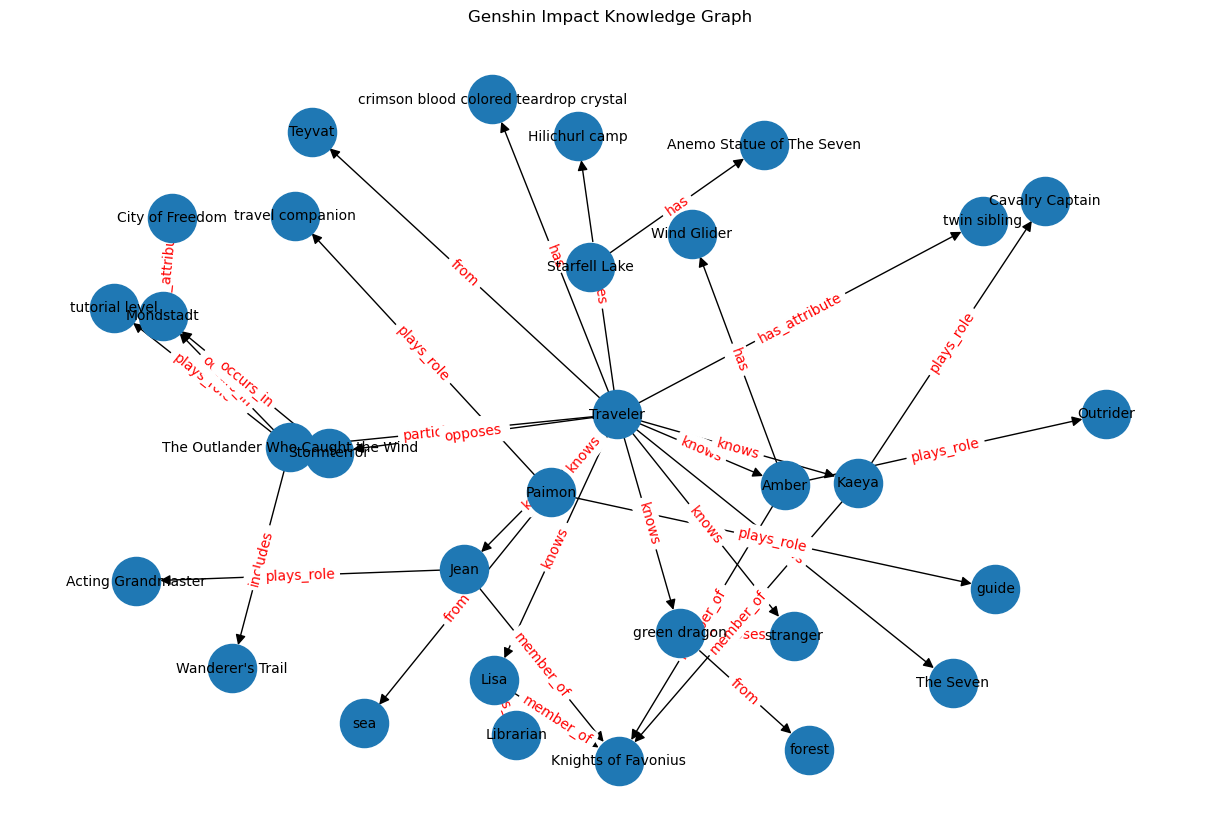

In [92]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter invalid triples
clean_triples = [
    t for t in triples
    if t.subject.strip() and t.relation.strip() and t.object.strip()
]

# Build directed graph
G = nx.DiGraph()
for t in clean_triples:
    G.add_edge(t.subject, t.object, relation=t.relation)

# Export to GraphML for future use
nx.write_graphml(G, "genshin_story_knowledge.graphml")
print("Exported genshin_story_knowledge.graphml")

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1200, font_size=10, arrowsize=15)

# Show relation labels on edges
edge_labels = nx.get_edge_attributes(G, "relation")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Genshin Impact Knowledge Graph")
plt.axis("off")
plt.show()


#### 3.2 Load & Query the Graph

You can later reload the exported .graphml file for further querying or debugging.

In [69]:
import networkx as nx

# Load from file
G = nx.read_graphml("genshin_story_knowledge.graphml")

# Basic stats
print(f"🧠 Nodes: {len(G.nodes)}")
print(f"🔗 Edges: {len(G.edges)}")


🧠 Nodes: 31
🔗 Edges: 34


#### 3.3 Example Query: Find Relations Involving "Paimon"

Let’s explore all edges where "Paimon" is either the subject or object:

In [74]:
paimon_relations = []
for u, v, data in G.edges(data=True):
    if 'paimon' in u.lower() or 'paimon' in v.lower():
        rel = data.get('relation', 'RELATED_TO')
        paimon_relations.append((u, rel, v))

# Display results
for head, rel, tail in paimon_relations:
    print(f"{head} --[{rel}]--> {tail}")


Traveler --[knows]--> Paimon
Paimon --[from]--> sea
Paimon --[plays_role]--> travel companion
Paimon --[plays_role]--> guide


#### Summary
This process enables:
- Visualizing lore relationships from wiki text as a graph
- Exporting the graph to standard formats (e.g., .graphml)
- Querying character connections, such as finding which events "Paimon" participates in

## Step 4: Knowledge Graph Construction & CSV Export

In this step, we extract structured triples from Genshin Impact's *Archon Quest* wiki pages using Gemini API, and export them as CSV files for graph database use (e.g., Neo4j).

### Workflow
1. Fetch all Archon Quest URLs from the Genshin Wiki.
2. Extract story content from each page.
3. Generate (subject, relation, object) triples via Gemini.
4. Save:
   - `all_acts_nodes.csv` → unique entities (nodes)
   - `all_acts_edges.csv` → relationships (edges)

### Sample Triple Output
| Subject     | Relation         | Object         |
| ----------- | ---------------- | -------------- |
| Traveler    | participates_in  | Prologue Act I |
| Stormterror | occurs_in        | Mondstadt      |
| Venti       | knows            | Traveler       |

These files are ready to be imported into Neo4j for semantic retrieval.

In [121]:
# Fetch all Archon Quest page URLs from the Genshin Wiki
def fetch_act_urls() -> List[str]:
    url = "https://genshin-impact.fandom.com/wiki/Archon_Quest"
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table", class_=lambda c: c and "article-table" in c)
    urls = []
    if not table:
        return urls

    # Loop through the table rows to find quest links
    for row in table.find_all("tr")[1:]:  # Skip header
        cells = row.find_all("td")
        if len(cells) >= 2:
            for a in cells[1].find_all("a", href=True):
                href = a["href"]
                if href.startswith("/wiki/"):
                    full = "https://genshin-impact.fandom.com" + href
                    urls.append(full)
    return list(dict.fromkeys(urls))  # Remove duplicates




# Main pipeline: Extract, generate triples, and save as CSV 
urls = fetch_act_urls()

# Track written node labels to avoid duplicates
written_nodes: Set[str] = set()

with open("all_acts_nodes.csv", "w", newline="", encoding="utf-8") as f_nodes, \
     open("all_acts_edges.csv", "w", newline="", encoding="utf-8") as f_edges:

    node_writer = csv.DictWriter(f_nodes, fieldnames=["id", "label"])
    edge_writer = csv.DictWriter(f_edges, fieldnames=["source", "target", "relation"])
    node_writer.writeheader()
    edge_writer.writeheader()

    for url in urls:
        print("Processing:", url)
        text = fetch_wiki_text(url)
        if not text.strip():
            continue

        triples = generate_triples_batched(text)

        for t in triples:
            subj = t.subject.strip()
            obj = t.object.strip()
            rel  = t.relation.strip()

            # Write each unique entity once
            if subj not in written_nodes:
                node_writer.writerow({"id": subj, "label": "Entity"})
                written_nodes.add(subj)
            if obj not in written_nodes:
                node_writer.writerow({"id": obj, "label": "Entity"})
                written_nodes.add(obj)

            # Write edge as directed relationship
            edge_writer.writerow({"source": subj, "target": obj, "relation": rel})

print("✅ Done: all_acts_nodes.csv & all_acts_edges.csv generated.")


Processing: https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind
Splitting into 1 chunk(s)...
Processing chunk 1/1
✅ Total extracted triples: 24
Processing: https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears
Splitting into 1 chunk(s)...
Processing chunk 1/1
✅ Total extracted triples: 0
Processing: https://genshin-impact.fandom.com/wiki/Adventure_Rank
Splitting into 1 chunk(s)...
Processing chunk 1/1
✅ Total extracted triples: 32
Processing: https://genshin-impact.fandom.com/wiki/Song_of_the_Dragon_and_Freedom
Splitting into 2 chunk(s)...
Processing chunk 1/2
Processing chunk 2/2
✅ Total extracted triples: 50
Processing: https://genshin-impact.fandom.com/wiki/Of_the_Land_Amidst_Monoliths
Splitting into 2 chunk(s)...
Processing chunk 1/2
Processing chunk 2/2
✅ Total extracted triples: 9
Processing: https://genshin-impact.fandom.com/wiki/Farewell,_Archaic_Lord
Splitting into 2 chunk(s)...
Processing chunk 1/2
Processing chunk 2/2
✅ Total extracted trip

## Step 5: Import CSV into Neo4j (Manual Upload)

Manually upload the generated knowledge graph CSV files into **Neo4j** to create a retrievable semantic graph for downstream question-answering and visualization tasks.

---

#### Files to Upload  
After completing **Step 4**, you should have the following two files:

- `all_acts_nodes.csv` – contains all **entities** (e.g., characters, items, events, locations)  
- `all_acts_edges.csv` – contains all **semantic relationships** (triples) between those entities

---

#### Upload Instructions  

1. Open **Neo4j Desktop** or go to the **Neo4j Web Interface** (e.g., `http://localhost:7474`)
2. Navigate to your project’s **Import** folder:
   - Click `Manage` → `Open Folder` → `Import`
3. Copy or move the following files into that `Import` folder:
   - `all_acts_nodes.csv`
   - `all_acts_edges.csv`

Once uploaded, you're ready to run Cypher commands to import the data into Neo4j as nodes and relationships.

---

#### 📺 Highly Recommended Tutorial  
If you're unfamiliar with how to import CSV files into Neo4j, this video was extremely helpful and easy to follow:

 **How to Upload a CSV file to a GRAPH database for FREE (Neo4j AuraDB)**  
 https://www.youtube.com/watch?v=lLx1BHdZY-o  
 Special thanks to the creator — this tutorial helped me a lot!


 

## Step 6: Question Answering with LangChain + Neo4j (GraphCypherQAChain)
Use a **LangChain-powered GraphQA pipeline** to perform semantic question answering over the knowledge graph stored in Neo4j. This allows us to transform natural language questions into **Cypher queries**, fetch structured results, and generate human-readable answers using an LLM.

---

#### What This Step Does

| Component           | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
|  **LLM (Gemini)** | Interprets both questions and structured query outputs for natural answers  |
|  **Neo4j Graph**  | Connects to the hosted Neo4j database containing our structured triples     |
|  **Prompt Templates** | Defines how to translate natural language into Cypher, and how to summarize query results |
|  **GraphCypherQAChain** | Combines LLM + Neo4j into an end-to-end QA chain                         |

---

#### Example Use Case

**Input question:**  
> _"Who knows Traveler?"_

**System output includes:**  
- The generated **Cypher query**
- The **raw results** from Neo4j
- The **structured answer** summarized by Gemini

---

####  Prerequisites

Before using this step:
- You must have successfully uploaded your CSV data into Neo4j (Step 5).
- Your Neo4j database must be accessible via the correct `url`, `username`, and `password`.
- The `relation` type should be used for all edges, and actual meanings must be stored in `relation` property.

---

This setup enables powerful semantic exploration of your Genshin knowledge graph via natural language!


In [266]:
from langchain_core.prompts import PromptTemplate
from langchain.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import google.generativeai as genai
import os


# Configure Gemini API with the secret key
genai.configure(api_key=API_KEY)

# Custom Gemini LLM wrapper to integrate with LangChain
class GeminiLLM(BaseLLM):
    model: str = "models/gemini-1.5-pro"
    temperature: float = 0.2
    max_output_tokens: int = 512

    def _generate(self, prompts: List[str], stop: Optional[List[str]] = None, **kwargs) -> LLMResult:
        responses = []
        gemini = genai.GenerativeModel(self.model)

        for prompt in prompts:
            response = gemini.generate_content(
                [{"role": "user", "parts": [{"text": prompt}]}],
                generation_config=genai.types.GenerationConfig(
                    temperature=self.temperature,
                    max_output_tokens=self.max_output_tokens
                )
            )
            text = response.text.strip()
            responses.append(ChatGeneration(message=AIMessage(content=text)))

        return LLMResult(generations=[[res] for res in responses])

    @property
    def _llm_type(self) -> str:
        return "gemini-llm"
        
# Step 1: Connect to Neo4j database
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USER,
    password=NEO4J_PASSWORD
)

# Step 2: Define Prompt to translate natural language → Cypher query
cypher_prompt = PromptTemplate(
    input_variables=["query", "id"],
    template="""
# Instruction:
You are an expert at translating natural language questions into Cypher queries. 
Based on the user's question and the entity ID "{id}", generate the **most semantically appropriate** Cypher query. 

The graph contains nodes of type `Entity`, connected via `:relation` edges.
Each `:relation` has a `relation` property indicating the actual relationship (e.g. "knows", "interacts_with", "member_of", "originates_from", etc).

## General Guidelines:

1. **If the query explicitly mentions two entities** (e.g., "Paimon and Zhongli"), search for all paths (not just shortest) between the two using up to 4 hops.
2. **If the query involves a specific relation type** (e.g., "origin", "creator", "is connected to the Archons"), filter by `r.relation`.
3. **If the query is about hidden or indirect links** (e.g., "Is Paimon related to Rex Lapis?"), include intermediate nodes and expand depth to 4–5 levels.
4. Use case-insensitive matching (`id =~ "(?i).*<name>.*"`) when the second entity is vague or undefined.
5. Prefer this return format: 
   `r.relation AS relation_type, b.id AS node`
6. Ensure that any `WHERE r.relation =~ ...` clauses appear *after* `UNWIND`, not before.

## Examples:

Q: "What relations does Traveler have?"  
MATCH (a:Entity {{id:"Traveler"}})-[r:relation]-(b:Entity)  
RETURN r.relation AS relation_type, b.id AS node

Q: "Is Paimon related to Morax?"  
MATCH p = (a:Entity {{id:"Paimon"}})-[*..4]-(b:Entity)  
WHERE b.id =~ "(?i).*morax.*" OR b.id =~ "(?i).*rex lapis.*" OR b.id =~ "(?i).*zhongli.*"  
WITH relationships(p) AS rels  
UNWIND rels AS r  
WITH r, endNode(r) AS b  
RETURN r.relation AS relation_type, b.id AS node

Q: "Paimon's origin and Geo Archon connection?"  
MATCH p = (a:Entity {{id:"Paimon"}})-[*..4]-(b:Entity)  
WHERE b.id =~ "(?i).*geo.*" OR b.id =~ "(?i).*archon.*" OR b.id =~ "(?i).*zhongli.*"  
WITH relationships(p) AS rels  
UNWIND rels AS r  
WITH r, endNode(r) AS b  
RETURN r.relation AS relation_type, b.id AS node

---

# Now generate the Cypher query:

Question: {query}  
Cypher:
"""
)

# Step 3: Define Prompt for summarizing Cypher query results into human-readable output
qa_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template="""
You are an expert at reading Cypher query results from a knowledge graph.

Question: {question}
Cypher Results:
{context}

List **all** nodes connected to the entity, grouped by `relation_type`.
Each group should list all connected nodes exactly as they appear, without summarizing.
Just output the structured result clearly.
"""
)

# Step 4: Initialize Gemini LLM with streaming output support
callbacks = [StreamingStdOutCallbackHandler()]
llm = GeminiLLM(
    callback_manager=CallbackManager(callbacks),
    verbose=True
)

# Step 5: Build the GraphCypherQAChain
chain = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph,
    cypher_prompt=cypher_prompt,
    qa_prompt=qa_prompt,
    allow_dangerous_requests=True,
    return_intermediate_steps=True,
    verbose=True,
    top_k=5
)

# Step 6: Invoke the QA chain with a natural language query and a node ID
output = chain.invoke({
    "query": "who knows Traveler?",
    "id":    "Traveler"
})

# Step 7: Print results and debug info
print(chain.input_keys)             # Expected input keys: {'query', 'id'}
print(chain.qa_chain.input_keys)    # Expected QA input keys: {'question', 'context'}

print("=== Generated Cypher ===")
print(output["query"])

print("\n=== Raw Records ===")
print(output["result"])

print("\n=== Summary ===")
print(output["result"])




> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (a:Entity)-[r:relation]->(b:Entity {id:"Traveler"})
WHERE r.relation =~ "(?i).*know.*" OR r.relation =~ "(?i).*knows.*"
RETURN r.relation AS relation_type, a.id AS node

Full Context:
[{'relation_type': 'knows', 'node': 'green dragon'}, {'relation_type': 'knows', 'node': 'stranger'}, {'relation_type': 'knows', 'node': 'Amber'}, {'relation_type': 'knows', 'node': 'Katheryne'}, {'relation_type': 'knows', 'node': 'Barbara'}]

> Finished chain.
['query']
['context', 'question']
=== Generated Cypher ===
who knows Traveler?

=== Raw Records ===
```json
{
  "knows": [
    "green dragon",
    "stranger",
    "Amber",
    "Katheryne",
    "Barbara"
  ]
}
```

=== Summary ===
```json
{
  "knows": [
    "green dragon",
    "stranger",
    "Amber",
    "Katheryne",
    "Barbara"
  ]
}
```


In [ ]:
# 2. Cypher Prompt：NL → Cypher（加入了 "id" 變數）
# PromptTemplate（語義存在屬性時用）
cypher_prompt = PromptTemplate(
    input_variables=["query", "id"],
    template="""
# Instruction:
You are an expert at translating natural language questions into Cypher queries. 
Based on the user's question and the entity ID "{id}", generate the **most semantically appropriate** Cypher query. 

The graph contains nodes of type `Entity`, connected via `:relation` edges.
Each `:relation` has a `relation` property indicating the actual relationship (e.g. "knows", "interacts_with", "member_of", "originates_from", etc).

## General Guidelines:

1. **If the query explicitly mentions two entities** (e.g., "Paimon and Zhongli"), search for all paths (not just shortest) between the two using up to 4 hops.
2. **If the query involves a specific relation type** (e.g., "origin", "creator", "is connected to the Archons"), filter by `r.relation`.
3. **If the query is about hidden or indirect links** (e.g., "Is Paimon related to Rex Lapis?"), include intermediate nodes and expand depth to 4–5 levels.
4. Use case-insensitive matching (`id =~ "(?i).*<name>.*"`) when the second entity is vague or undefined.
5. Prefer this return format: 
   `r.relation AS relation_type, b.id AS node`
6. Ensure that any `WHERE r.relation =~ ...` clauses appear *after* `UNWIND`, not before.

## Examples:

Q: "What relations does Traveler have?"  
MATCH (a:Entity {{id:"Traveler"}})-[r:relation]-(b:Entity)  
RETURN r.relation AS relation_type, b.id AS node

Q: "Is Paimon related to Morax?"  
MATCH p = (a:Entity {{id:"Paimon"}})-[*..4]-(b:Entity)  
WHERE b.id =~ "(?i).*morax.*" OR b.id =~ "(?i).*rex lapis.*" OR b.id =~ "(?i).*zhongli.*"  
WITH relationships(p) AS rels  
UNWIND rels AS r  
WITH r, endNode(r) AS b  
RETURN r.relation AS relation_type, b.id AS node

Q: "Paimon's origin and Geo Archon connection?"  
MATCH p = (a:Entity {{id:"Paimon"}})-[*..4]-(b:Entity)  
WHERE b.id =~ "(?i).*geo.*" OR b.id =~ "(?i).*archon.*" OR b.id =~ "(?i).*zhongli.*"  
WITH relationships(p) AS rels  
UNWIND rels AS r  
WITH r, endNode(r) AS b  
RETURN r.relation AS relation_type, b.id AS node

---

# Now generate the Cypher query:

Question: {query}  
Cypher:
"""
)

qa_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template="""
You are an expert at reading Cypher query results from a knowledge graph.

Question: {question}
Cypher Results:
{context}

List **all** nodes connected to the entity, grouped by `relation_type`.
Each group should list all connected nodes exactly as they appear, without summarizing.
Just output the structured result clearly.
"""
)


# 4. LLM + Callbacks
callbacks = [StreamingStdOutCallbackHandler()]
llm = GeminiLLM(
    callback_manager=CallbackManager(callbacks),
    verbose=True
)

# 5. 构建 Chain
chain = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph,
    cypher_prompt=cypher_prompt,
    qa_prompt=qa_prompt,
    allow_dangerous_requests=True,
    return_intermediate_steps=True,
    verbose=True,
    top_k=10
)


## Step 7: Create RAG Vector Store from Genshin Wiki (Archon Quest)

Transform all **Archon Quest** content from the Genshin Wiki into chunked documents, embed them using the **Gemini API**, and store them in a **Chroma** vector database for use in RAG (Retrieval-Augmented Generation).

---

### Workflow Overview

| Stage                        | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **URL Collection**        | Scrape all Archon Quest page links from the Genshin Wiki.                  |
| **Text Extraction**       | Parse paragraphs and their associated headings (`<h2>`, `<h3>`) as context.|
| **Chunking**              | Split long texts into overlapping segments while preserving section titles.|
| **Embedding (Gemini)**    | Use Google Gemini's embedding API to vectorize each document chunk.        |
| **Vector Store (Chroma)** | Store all embedded chunks and metadata in a local Chroma vector DB.        |




In [179]:
from google.genai import types
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Scrape Archon Quest URLs & Extract Page Text with Headings
def fetch_page_text_with_headings(url: str) -> List[Document]:
    """
    Extracts <p> text blocks from a given Genshin Wiki page and assigns each to the most recent <h2> or <h3> heading.
    Returns a list of LangChain Document objects with section titles as metadata.
    """
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(resp.text, "html.parser")
    div = soup.find("div", class_="mw-parser-output")
    docs = []
    current_heading = ""
    if not div:
        return docs
    for elem in div.children:
        if elem.name in ["h2", "h3"]:
            current_heading = elem.get_text(strip=True)
        elif elem.name == "p":
            text = elem.get_text(strip=True)
            if text:
                docs.append(
                    Document(
                        page_content=text,
                        metadata={
                            "source": url,
                            "section_title": current_heading
                        }
                    )
                )
    return docs


# Define Custom Gemini Embeddings Class

EMBED_MODEL = "models/text-embedding-004"

class GeminiEmbeddings(Embeddings):
    """
    Custom embedding class using Google's Gemini embedding API for documents and queries.
    """
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        all_embs = []
        batch_size = 50
        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]
            resp = client.models.embed_content(
                model=EMBED_MODEL,
                contents=batch,
                config=types.EmbedContentConfig(
                    task_type="RETRIEVAL_DOCUMENT",
                    title="; ".join([t[:50] for t in batch])
                )
            )
            all_embs.extend(e.values for e in resp.embeddings)
        return all_embs

    def embed_query(self, text: str) -> List[float]:
        """
        Embeds a user query using Gemini's RETRIEVAL_QUERY mode.
        """
        resp = client.models.embed_content(
            model=EMBED_MODEL,
            contents=[text],
            config=types.EmbedContentConfig(
                task_type="RETRIEVAL_QUERY",
            )
        )
        return resp.embeddings[0].values


# Configure Recursive Text Splitter with Section Headings

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,          # Max chunk length
    chunk_overlap=200,       # Overlap between chunks
    length_function=len
)


# Process and Deduplicate All Wiki Page Documents

urls = fetch_act_urls()
docs: List[Document] = []
seen_hashes = set()

for url in urls:
    page_docs = fetch_page_text_with_headings(url)
    for doc in page_docs:
        # Combine section heading and paragraph into one content block
        section = doc.metadata.get("section_title", "")
        content = f"### {section}\n{doc.page_content}" if section else doc.page_content
        chunks = splitter.split_text(content)
        for idx, chunk in enumerate(chunks):
            h = hashlib.md5(chunk.encode("utf-8")).hexdigest()
            if h not in seen_hashes:
                seen_hashes.add(h)
                docs.append(
                    Document(
                        page_content=chunk,
                        metadata={
                            "source": doc.metadata["source"],
                            "chunk_index": idx,
                            "section_title": section
                        }
                    )
                )

print(f"✅ Total unique document chunks: {len(docs)}")


# Create and Persist Chroma Vector Store

vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=GeminiEmbeddings(),
    persist_directory="./genshin_chroma"
)
vectorstore.persist()
print("✅ Vector store created and saved to ./genshin_chroma")

print("Docs in vectorstore:", vectorstore._collection.count())

✅ Total unique document chunks: 381
✅ Vector store created and saved to ./genshin_chroma


#### Query the Vector Store (Quick Test)

This step verifies that our Chroma-based vector store is working correctly by checking the number of documents it contains and performing a basic semantic query.


In [197]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
query = "What is the relationship between the Traveler and Nahida in Sumeru?"
results = retriever.get_relevant_documents(query)

print("\n📝 Top relevant chunks:")

for doc in results:
    print(f"- Source: {doc.metadata['source']}｜chunk {doc.metadata['chunk_index']}")
    print(f"  Content: {doc.page_content[:500]}...\n")



📝 Top relevant chunks:
- Source: https://genshin-impact.fandom.com/wiki/Akasha_Pulses,_the_Kalpa_Flame_Rises｜chunk 0
  Content: ### Summary[]
Heading into the Sanctuary, the Traveler and Paimon meet Nahida in person for the first time. Nahida apologizes for putting them through situations she caused, but they decline the apology as she wasn't at fault. Now knowing the full extent of the damage, Nahida reverts the Akasha to be used by herself only and revoke all of the sages' access, make them pay for their crimes, and also to stop the false god. She advises them to prepare themselves....

- Source: https://genshin-impact.fandom.com/wiki/Akasha_Pulses,_the_Kalpa_Flame_Rises｜chunk 0
  Content: ### Summary[]
Heading into the Sanctuary, the Traveler and Paimon meet Nahida in person for the first time. Nahida apologizes for putting them through situations she caused, but they decline the apology as she wasn't at fault. Now knowing the full extent of the damage, Nahida reverts the Akasha to

##  Step 8: Build BM25 Retriever for Local Keyword-Based Search

Use the classic **BM25 ranking algorithm** to retrieve relevant chunks from the Archon Quest text based on keyword overlap.  
This provides a lightweight alternative to dense vector retrieval for text-based search.

---

###  What This Step Does

| Stage              | Description                                                                 |
| ------------------ | --------------------------------------------------------------------------- |
|  **Text Loading** | Reads raw story text from `archon_quests.txt`                              |
|  **Chunking**     | Splits the full text into overlapping chunks to preserve context           |
|  **Documents**    | Wraps each chunk into a LangChain `Document` format for indexing            |
|  **BM25 Indexing**| Uses `BM25Retriever` to enable lexical keyword search on the document chunks |

---


#### Crawl Archon Quest Pages & Save as Plain Text
This step scrapes all Archon Quest story pages from the Genshin Impact Wiki and stores the raw paragraph text into a `.txt` file.

In [211]:
# Step 1: Fetch all Archon Quest page URLs from the Genshin Impact Wiki
urls = fetch_act_urls()
print(f"Found {len(urls)} Archon Quest URLs")

# Step 2: Crawl content from each page and save to local .txt file
output_path = "archon_quests.txt"
success_count = 0
fail_count = 0

with open(output_path, "w", encoding="utf-8") as f:
    for i, url in enumerate(urls, 1):
        print(f" ({i}/{len(urls)}) Fetching: {url}")
        try:
            content = fetch_wiki_text(url)
            f.write(f"=== {url} ===\n")
            if content:
                f.write(content + "\n\n")
                success_count += 1
            else:
                f.write("(No content found)\n\n")
        except Exception as e:
            print(f"⚠️ Error on {url}: {e}")
            f.write(f"(Failed to fetch content: {e})\n\n")
            fail_count += 1

print(f"Completed. Saved to `{output_path}`")
print(f"Pages fetched successfully: {success_count}")
print(f"Pages failed: {fail_count}")


Found 42 Archon Quest URLs
 (1/42) Fetching: https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind
 (2/42) Fetching: https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears
 (3/42) Fetching: https://genshin-impact.fandom.com/wiki/Adventure_Rank
 (4/42) Fetching: https://genshin-impact.fandom.com/wiki/Song_of_the_Dragon_and_Freedom
 (5/42) Fetching: https://genshin-impact.fandom.com/wiki/Of_the_Land_Amidst_Monoliths
 (6/42) Fetching: https://genshin-impact.fandom.com/wiki/Farewell,_Archaic_Lord
 (7/42) Fetching: https://genshin-impact.fandom.com/wiki/A_New_Star_Approaches
 (8/42) Fetching: https://genshin-impact.fandom.com/wiki/Bough_Keeper:_Dainsleif
 (9/42) Fetching: https://genshin-impact.fandom.com/wiki/We_Will_Be_Reunited
 (10/42) Fetching: https://genshin-impact.fandom.com/wiki/Lupus_Minor_Chapter
 (11/42) Fetching: https://genshin-impact.fandom.com/wiki/The_Meaning_of_Lupical
 (12/42) Fetching: https://genshin-impact.fandom.com/wiki/Autumn_Winds,_Sc

In [231]:
# --- BM25 Retriever Setup for Keyword-Based Search ---

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.retrievers import BM25Retriever

# Step 1: Load the saved story content from the local text file
with open("archon_quests.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

# Step 2: Split the full text into manageable chunks to preserve semantic continuity
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,      # Maximum characters per chunk
    chunk_overlap=50     # Overlap to reduce information loss across boundaries
)
text_chunks = splitter.split_text(raw_text)

# Step 3: Convert chunks into LangChain-compatible Document objects
documents = [
    Document(page_content=chunk, metadata={"source": f"chunk_{i}"})
    for i, chunk in enumerate(text_chunks)
]

# Step 4: Initialize a BM25Retriever for efficient keyword-based retrieval
bm25_retriever = BM25Retriever.from_documents(documents)
bm25_retriever.k = 3  # Top K results to return

# Step 5: Run a sample query
sample_query = "Who is Paimon?"
results = bm25_retriever.get_relevant_documents(sample_query)

# Step 6: Display the most relevant document chunks
print("📝 Top matching chunks:\n")
for doc in results:
    print(f"🔹 {doc.metadata['source']}")
    print(doc.page_content[:300] + "...\n")


📝 Top matching chunks:

🔹 chunk_0
=== https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind ===
The Outlander Who Caught the WindMondstadt's Quest ActQuest TypeChapterArchonPrologueActIPreviousNextN/AFor a Tomorrow Without TearsRequirementsArchon QuestRequirement(s)Wanderer's TrailRewards100The Outlander Who Caugh...

🔹 chunk_7
After dealing with the temples, Paimon suggests that they return to the knights' headquarters to see what they should do next.
16Charactersappear in this Act:
There are3Achievementsobtainable fromThe Outlander Who Caught the Wind:...

🔹 chunk_8
=== https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears ===
For a Tomorrow Without TearsMondstadt's Quest ActQuest TypeChapterArchonPrologueActIIPreviousNextThe Outlander Who Caught the WindSong of the Dragon and FreedomRequirementsAdventure RankRequired10Rewards100For a Tomorrow Wit...



## Step 9: Multi-Source Question Answering with KG + RAG + BM25  
Answer user questions about *Genshin Impact* lore by combining results from:
- **Knowledge Graph (KG)** via Cypher QA
- **Semantic Retrieval (RAG)** using Gemini embeddings + Chroma
- **Lexical Retrieval (BM25)** using keyword-based search

This hybrid approach ensures broad coverage and rich narrative context, even for complex or ambiguous queries.

---

### What This Step Does

| Stage                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| Query Rewriting      | Reformulates informal or vague questions into clearer search-oriented input |
| Intent Classification | Detects the type of question: character, event, quest, location, or general |
| Query Decomposition  | Breaks complex queries into simpler sub-questions                            |
| Query Expansion       | Paraphrases and augments queries to improve retrieval diversity              |
| Multi-Source Retrieval | Queries **KG**, **RAG**, and **BM25** independently for relevant chunks     |
| Final Answer Generation | Uses Gemini to summarize results into a cohesive, lore-accurate answer    |





In [3]:
# Rewrites vague user queries into clear, formal search queries suitable for retrieval
def rewrite_query_for_search(query: str) -> str:
    prompt = f"""
Rewrite the following informal or unclear user query into a formal, unambiguous search query.

Original: "{query}"

Rewritten:
"""
    response = genai.GenerativeModel("gemini-1.5-pro").generate_content(prompt)
    return response.text.strip()


In [7]:
# Classifies the intent of a query into one of five categories for more targeted processing
def classify_intent_llm(query: str) -> str:
    prompt = f"""
You are a Genshin Impact search assistant.
Classify the user query into one of the following intents:
["character_relationship", "plot_event", "location_info", "quest_requirement", "general_knowledge"]

Query: "{query}"

Return only the intent.
"""
    response = genai.GenerativeModel("gemini-1.5-pro").generate_content(prompt)
    return response.text.strip()


In [9]:
# Decomposes complex queries into simpler sub-questions for more effective retrieval
# 使用者提出複雜問題時，LLM 拆成多個小問題，有助於提高 RAG 召回率與精準度。
def decompose_query(query: str) -> list[str]:
    prompt = f"""
You are a smart assistant. Break the user's complex query into 2–4 simpler sub-questions.

Query: "{query}"

Return the result as a JSON list of strings only, without any explanation or markdown.
"""
    response = genai.GenerativeModel("gemini-1.5-pro").generate_content(prompt)
    
    # 清理可能含有 ```json 或其他 markdown 語法
    cleaned = re.sub(r"```json|```", "", response.text.strip())
    
    try:
        return json.loads(cleaned)
    except Exception as e:
        print("❌ JSON parsing error:", e)
        print("🔎 Raw response:", response.text)
        return [query]  # fallback: 回傳原始查詢


In [17]:
#  3.3 查詢重寫（Query Rewriting）
# 使用者輸入口語、模糊或錯誤的查詢時，LLM 自動將其重寫為適合檢索的清晰查詢。
def rewrite_query_for_search(query: str) -> str:
    prompt = f"""
Rewrite the following informal or unclear user query into a formal, unambiguous search query.

Original: "{query}"

Rewritten:
"""
    response = genai.GenerativeModel("gemini-1.5-pro").generate_content(prompt)
    return response.text.strip()

In [19]:
# Expands a given query into several related phrasings to improve recall in retrieval
def expand_query_with_llm(question: str) -> List[str]:
    import json

    prompt = f"""
You are a Genshin Impact lore expert.

Please expand the following user question into **3 to 5 semantically related search queries** to increase retrieval coverage.

Original question: "{question}"

Requirements:
- Include paraphrases, synonyms, or alternate phrasings.
- Keep each query clear and self-contained.
- Return the output as a **pure JSON array of strings**, and nothing else.
- Format strictly like: ["query1", "query2", "query3", ...]

Now return only the JSON list:
"""
    model = genai.GenerativeModel("gemini-1.5-pro")
    response = model.generate_content(prompt)

    raw = response.text.strip()
    
    # First try: clean JSON
    try:
        return json.loads(raw)
    except json.JSONDecodeError:
        pass

    # Second try: extract JSON-like list manually
    try:
        import re
        match = re.search(r"\[.*?\]", raw, re.DOTALL)
        if match:
            return json.loads(match.group(0))
    except:
        pass

    # Fallback
    return [question]


NameError: name 'List' is not defined

In [21]:
# Selects the most semantically diverse queries based on cosine similarity of embeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def pick_diverse_queries(queries: List[str], embedding_model, top_k: int = 5) -> List[str]:
    # Generate embeddings for each query
    embeddings = embedding_model.embed_documents(queries)

    # Calculate cosine similarity between all pairs
    sim_matrix = cosine_similarity(embeddings)

    # Mask out self-similarity
    np.fill_diagonal(sim_matrix, -1)

    # Compute average similarity to all other queries
    avg_sim = np.mean(sim_matrix, axis=1)

    # Return the k queries with lowest average similarity (most unique)
    diverse_indices = np.argsort(avg_sim)[:top_k]
    return [queries[i] for i in diverse_indices]


NameError: name 'List' is not defined

In [288]:
def generate_answer_from_sections(question, kg_section, rag_section, bm25_section) -> str:
    model = genai.GenerativeModel("gemini-1.5-pro")
    prompt = f"""
You are a professional narrative writer and expert in Genshin Impact lore.

Based on the provided structured knowledge graph and retrieved story excerpts, your task is to **retell the complete story** relevant to the topic below. Use the input materials as your only sources.

You must:
- Use **only** the provided materials. Do not invent or guess any details.
- Write in **clear, formal, and engaging prose** suitable for a lore archive or detailed summary.
- Organize the story in **chronological order** (or logical topic groups if time is unclear).
- Incorporate **key characters, locations, items, and events** naturally into the story.
- Provide rich descriptions while remaining strictly faithful to the source.

If some information is unclear or incomplete, acknowledge that appropriately.

---

# Topic:
{question}

---

# Knowledge Graph Summary:
{kg_section}

---

# Retrieved Narrative Excerpts:
{rag_section}

---
# BM25 Retrieved Info:
{bm25_section}

---

# Story (Long with detail):
"""
    response = model.generate_content(prompt)
    return response.text.strip()



# --- 🔍 啟動多階段查詢處理與三源檢索 ---
query = "what's paimon's deal with zhongli?"
entity_id = "Paimon"

print("📥 Original Query:", query)

# 1. 重寫查詢
rewritten_query = rewrite_query_for_search(query)
print("📝 Rewritten Query:\n", rewritten_query)

# 2. 查詢意圖
intent = classify_intent_llm(rewritten_query)
print("🔍 Classified Intent:\n", intent)

# 3. 查詢拆解
sub_queries = decompose_query(rewritten_query)
print("🧩 Decomposed Sub-Queries:")
for i, q in enumerate(sub_queries):
    print(f"  {i+1}. {q}")

# 4. 擴展查詢
expanded_queries = []
print("🧠 Expanded Queries:")
for sub_q in sub_queries:
    expanded = expand_query_with_llm(sub_q)
    expanded_queries.extend(expanded)
    for q in expanded:
        print("  -", q)

# 5. 多源檢索
print("\n🔎 Performing multi-source retrieval...")

# 原擴展查詢
expanded_queries = []
for sub_q in sub_queries:
    expanded = expand_query_with_llm(sub_q)
    expanded_queries.extend(expanded)

# 選出語意最分散的 Top 3
top3_expanded_queries = pick_diverse_queries(expanded_queries, embedding_model=embedding, top_k=3)

# 印出
print("🧠 Top 3 Diverse Expanded Queries:")
for q in top3_expanded_queries:
    print("  -", q)


# KG
kg_results = []
for q in top3_expanded_queries:
    output = chain.invoke({"query": q, "id": entity_id})
    if isinstance(output, dict) and "text" in output:
        kg_results.append(output["text"])
    elif isinstance(output, str):
        kg_results.append(output)
kg_result = "\n".join(set(kg_results))

# RAG
rag_docs = []
for q in expanded_queries:
    docs = vectorstore.similarity_search(q, k=3)
    rag_docs.extend(docs)
rag_result = "\n".join(set(d.page_content for d in rag_docs))

print("\n📘 RAG Retrieved Documents:")
for i, doc in enumerate(rag_docs):
    print(f"  [{i+1}] (source: {doc.metadata.get('source', 'N/A')})")
    print(f"      {doc.page_content[:300]}...\n")  # 印前300字即可
    
    
# BM25
bm25_docs = []
for q in expanded_queries:
    docs = bm25_retriever.get_relevant_documents(q)
    bm25_docs.extend(docs)
bm25_result = "\n".join(set(d.page_content for d in bm25_docs))

print("\n📙 BM25 Retrieved Documents:")
for i, doc in enumerate(bm25_docs):
    print(f"  [{i+1}] (source: {doc.metadata.get('source', 'N/A')})")
    print(f"      {doc.page_content[:300]}...\n")  # 印前300字即可
    
    
# 6. 生成最終回答
final_answer = generate_answer_from_sections(
    question=query,
    kg_section=kg_result,
    rag_section=rag_result,
    bm25_section=bm25_result
)

print("\n🧠 最終回答：\n", final_answer)

📥 Original Query: what's paimon's deal with zhongli?
📝 Rewritten Query:
 "Relationship between Paimon and Zhongli in Genshin Impact" 

or

"Paimon and Zhongli interactions in Genshin Impact"

or 

"Paimon's connection to Zhongli (Genshin Impact)"
🔍 Classified Intent:
 character_relationship
🧩 Decomposed Sub-Queries:
  1. What is Paimon's role in relation to Zhongli's story quests or events in Genshin Impact?
  2. How does Paimon typically interact with Zhongli (e.g., respectful, informal, teasing) in Genshin Impact?
  3. Are there any notable instances of Paimon and Zhongli's interactions that reveal information about either character or the lore of Genshin Impact?
🧠 Expanded Queries:
  - Paimon's involvement in Zhongli's story quests Genshin Impact
  - Paimon and Zhongli interactions in Genshin Impact Archon Quests
  - Paimon's role in Liyue story quests related to Morax
  - Paimon's significance in Zhongli's character story and events
  - Paimon's dialogue and actions during Zhongli 